## Importing packages

In [ ]:
%pip install stable-baselines3 gym-anytrading gym

In [ ]:
%pip install yfinance

In [1]:
import gym
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Downloading Ticker Data

In [2]:
import yfinance as yf
gme = yf.Ticker('GME')
print(gme)

yfinance.Ticker object <GME>


In [3]:
df = yf.download('GME', period='1d',start='2020-03-16', end='2022-03-15')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4.37,4866700
2020-03-17,4.40,4.65,4.11,4.23,4.23,3562200
2020-03-18,4.10,4.25,3.50,3.77,3.77,3651700
2020-03-19,3.71,4.20,3.55,4.19,4.19,5039500
2020-03-20,4.08,4.08,3.65,3.76,3.76,7722200


In [4]:
df.shape

(504, 6)

In [5]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

## Build Environment

Using gym_anytrading, set up stock-v0 environment.

DF is the dataframe.

Frame_bound = the portion of the dataframe we wish to consider (start from window_size)

window_size - the number of previous timesteps the bot can access while making prediction

In [6]:
env = gym.make('stocks-v0', df=df, frame_bound=(10,df.shape[0]-50), window_size=5)

Taking random steps here. Obviously we don't want to do this to get meaningful results.

info {'total_reward': 112.6199586391449, 'total_profit': 0.3666458698371053, 'position': 1}


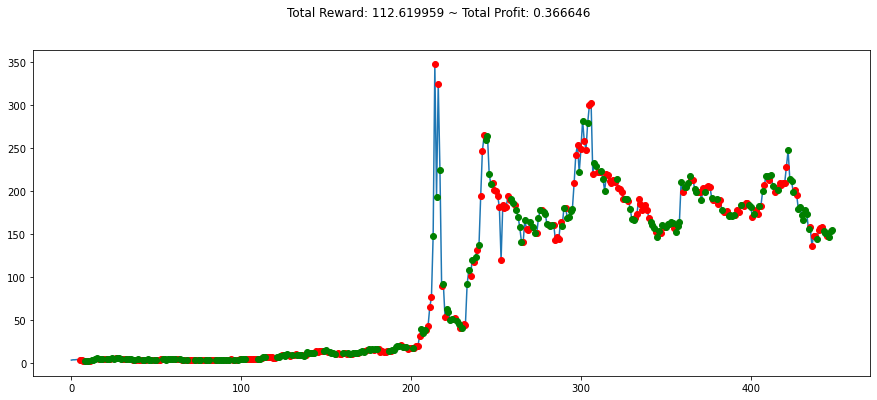

In [7]:
# Get initial state
state = env.reset()

# Run through random steps of the environment
while True:
    #Take a random action, either buy or sell. No HOLD action present in this gym
    action = env.action_space.sample()

    #Apply the action
    n_state, reward, done, info = env.step(action)
    if done:
        #If the episode is done, reset the environment
        print('info', info)
        break

#Visualize the environment
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## Using Stable Baselines3

In [8]:
# Create new environment to use with Stable Baselines
# The lambda function is used to create a new environment if needed, but here we won't
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(10,df.shape[0]-50), window_size=5)
env = DummyVecEnv([env_maker])

In [9]:

model = A2C('MlpPolicy', env, verbose=1) #LSTM will help the model keep context
model.learn(total_timesteps=10000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 196      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | -0.103   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.115    |
|    value_loss         | 0.157    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 195      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.561   |
|    explained_variance | -74.2    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.00344 |
|    value_loss     

## Evaluation

In [10]:
env = gym.make('stocks-v0', df=df, frame_bound=(df.shape[0]-40,df.shape[0]), window_size=5)
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info:", info)
        break
    

info: {'total_reward': 27.470001220703125, 'total_profit': 0.8412023921207462, 'position': 1}


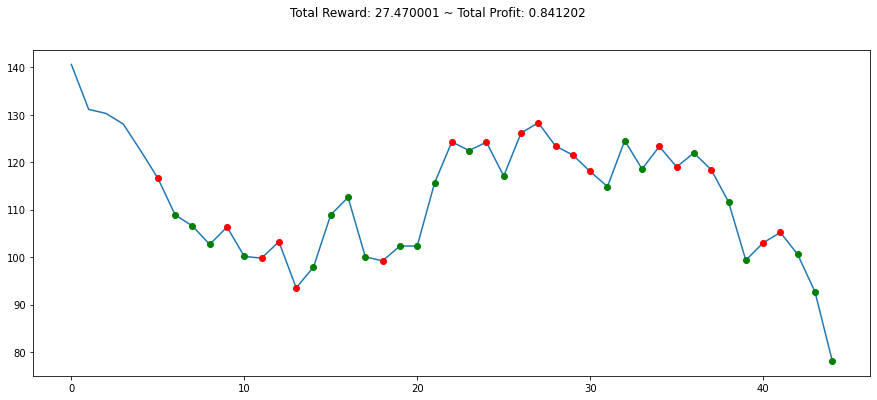

In [11]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## Adding Custom Signals and improving the bot

In [12]:
%pip install finta

Note: you may need to restart the kernel to use updated packages.


In [13]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [14]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)

In [15]:
df.head(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4.37,4866700,NaN,NaN,NaN
2020-03-17,4.40,4.65,4.11,4.23,4.23,3562200,NaN,0.000000,-3562200.0
2020-03-18,4.10,4.25,3.50,3.77,3.77,3651700,NaN,0.000000,-7213900.0
2020-03-19,3.71,4.20,3.55,4.19,4.19,5039500,NaN,43.394842,-2174400.0
2020-03-20,4.08,4.08,3.65,3.76,3.76,7722200,NaN,29.351461,-9896600.0
2020-03-23,3.58,3.86,3.50,3.81,3.81,6009800,NaN,32.102965,-3886800.0
2020-03-24,3.95,4.21,3.89,4.16,4.16,6805600,NaN,47.512947,2918800.0
2020-03-25,4.15,4.49,4.04,4.17,4.17,3592100,NaN,47.876953,6510900.0
2020-03-26,4.24,4.71,4.24,4.41,4.41,6185700,NaN,55.799555,12696600.0


In [16]:
df.fillna(0, inplace=True)
df.head(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4.37,4866700,0.000000,0.000000,0.0
2020-03-17,4.40,4.65,4.11,4.23,4.23,3562200,0.000000,0.000000,-3562200.0
2020-03-18,4.10,4.25,3.50,3.77,3.77,3651700,0.000000,0.000000,-7213900.0
2020-03-19,3.71,4.20,3.55,4.19,4.19,5039500,0.000000,43.394842,-2174400.0
2020-03-20,4.08,4.08,3.65,3.76,3.76,7722200,0.000000,29.351461,-9896600.0
2020-03-23,3.58,3.86,3.50,3.81,3.81,6009800,0.000000,32.102965,-3886800.0
2020-03-24,3.95,4.21,3.89,4.16,4.16,6805600,0.000000,47.512947,2918800.0
2020-03-25,4.15,4.49,4.04,4.17,4.17,3592100,0.000000,47.876953,6510900.0
2020-03-26,4.24,4.71,4.24,4.41,4.41,6185700,0.000000,55.799555,12696600.0


In [17]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [73]:
class CustomTradingEnv(StocksEnv):
    #Native function inside StocksEnv
    #By default it just considered price and price difference
    process_data = add_signals

env2 = CustomTradingEnv(df=df, window_size=12, frame_bound=(30, 400))

In [74]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [75]:
from stable_baselines3 import PPO, DQN

In [76]:
model = A2C('MlpPolicy', env, verbose=1) #LSTM will help the model keep context
model.learn(total_timesteps=10000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 226      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -7.74    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.111   |
|    value_loss         | 0.0377   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 226      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.618   |
|    explained_variance | -1.3e+04 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.644   |
|    value_loss     

In [79]:
env = CustomTradingEnv(df=df, window_size=12, frame_bound=(405, 450))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info:", info)
        break
    

info: {'total_reward': 0.0, 'total_profit': 0.8826001396071338, 'position': 1}


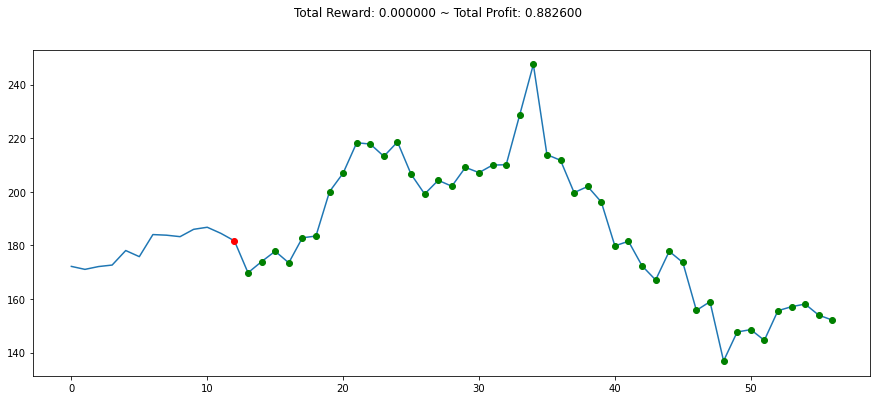

In [80]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()